In [2]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import matplotlib.pyplot as plt
import numpy as np
import joblib


## **Phase 1**

In [ ]:
# Cell 2: Load Data
df = pd.read_excel('dataset.xlsx')
print("Shape:", df.shape)
display(df.head())


Shape: (500, 17)


,Pilot_Total_Flight_Hours,Pilot_Fatigue_Level,Pilot_Training_Level,Co-Pilot_Total_Flight_Hours,Co-Pilot_Fatigue_Level,Co-Pilot_Training_Level,Aircraft_Model,Aircraft_Age_Years,Days_Since_Last_Maintenance,System_Status,Engine_Cycles,Weather_Condition,Visibility_km,Wind_Speed_knots,Bird_Activity,Season,Incident
0,15995,5,Intermediate,5590,3,Basic,B787,13,125,Healthy,37264,Clear,2.6,56,High,Summer,No
1,12164,5,Intermediate,6465,3,Intermediate,A330,25,110,Healthy,42151,Storm,8.5,22,Low,Autumn,No
2,4626,3,Advanced,14623,5,Intermediate,B737,18,86,Healthy,13418,Fog,4.9,42,Low,Winter,No
3,11563,3,Advanced,1885,5,Basic,A350,4,120,Healthy,17300,Fog,5.2,5,Medium,Summer,Yes
4,969,4,Intermediate,2633,4,Basic,B787,28,127,Healthy,182,Snow,3.2,46,High,Summer,No


In [4]:
# Cell 3: Basic Info
print(df.info())
print("\nMissing values:\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Pilot_Total_Flight_Hours     500 non-null    int64  
 1   Pilot_Fatigue_Level          500 non-null    int64  
 2   Pilot_Training_Level         500 non-null    object 
 3   Co-Pilot_Total_Flight_Hours  500 non-null    int64  
 4   Co-Pilot_Fatigue_Level       500 non-null    int64  
 5   Co-Pilot_Training_Level      500 non-null    object 
 6   Aircraft_Model               500 non-null    object 
 7   Aircraft_Age_Years           500 non-null    int64  
 8   Days_Since_Last_Maintenance  500 non-null    int64  
 9   System_Status                500 non-null    object 
 10  Engine_Cycles                500 non-null    int64  
 11  Weather_Condition            500 non-null    object 
 12  Visibility_km                500 non-null    float64
 13  Wind_Speed_knots    

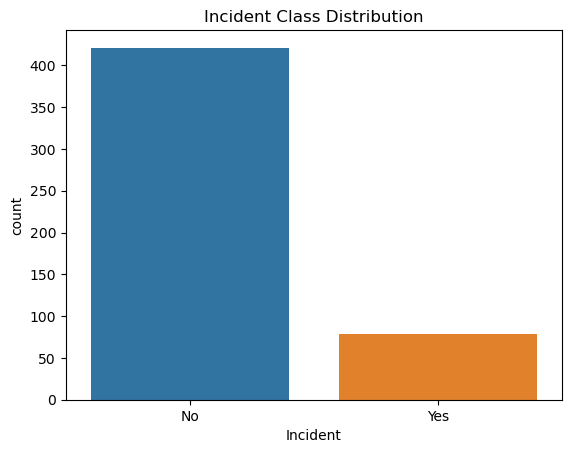

Incident
No     0.842
Yes    0.158
Name: proportion, dtype: float64


In [5]:
# Cell 4: Incident Distribution
sns.countplot(data=df, x='Incident')
plt.title('Incident Class Distribution')
plt.show()

print(df['Incident'].value_counts(normalize=True))


In [6]:
# Cell 5: Summary Stats for Numeric Columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
display(df[numeric_cols].describe())


,Pilot_Total_Flight_Hours,Pilot_Fatigue_Level,Co-Pilot_Total_Flight_Hours,Co-Pilot_Fatigue_Level,Aircraft_Age_Years,Days_Since_Last_Maintenance,Engine_Cycles,Visibility_km,Wind_Speed_knots
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,9680.090000,2.962000,10513.556000,2.960000,15.108000,184.474000,25190.36600,4.843000,30.982000
std,5847.013606,1.442469,5714.985686,1.434753,9.048984,107.330336,14592.35939,2.847066,17.344259
min,209.000000,1.000000,211.000000,1.000000,0.000000,1.000000,182.00000,0.100000,0.000000
25%,4426.000000,2.000000,5677.000000,2.000000,7.000000,90.750000,12255.00000,2.300000,17.000000
50%,9642.500000,3.000000,10639.500000,3.000000,15.000000,177.000000,26036.50000,4.900000,31.000000
75%,14486.500000,4.000000,15707.250000,4.000000,23.000000,280.250000,37059.75000,7.000000,46.000000
max,19919.000000,5.000000,19969.000000,5.000000,30.000000,365.000000,49931.00000,10.000000,60.000000


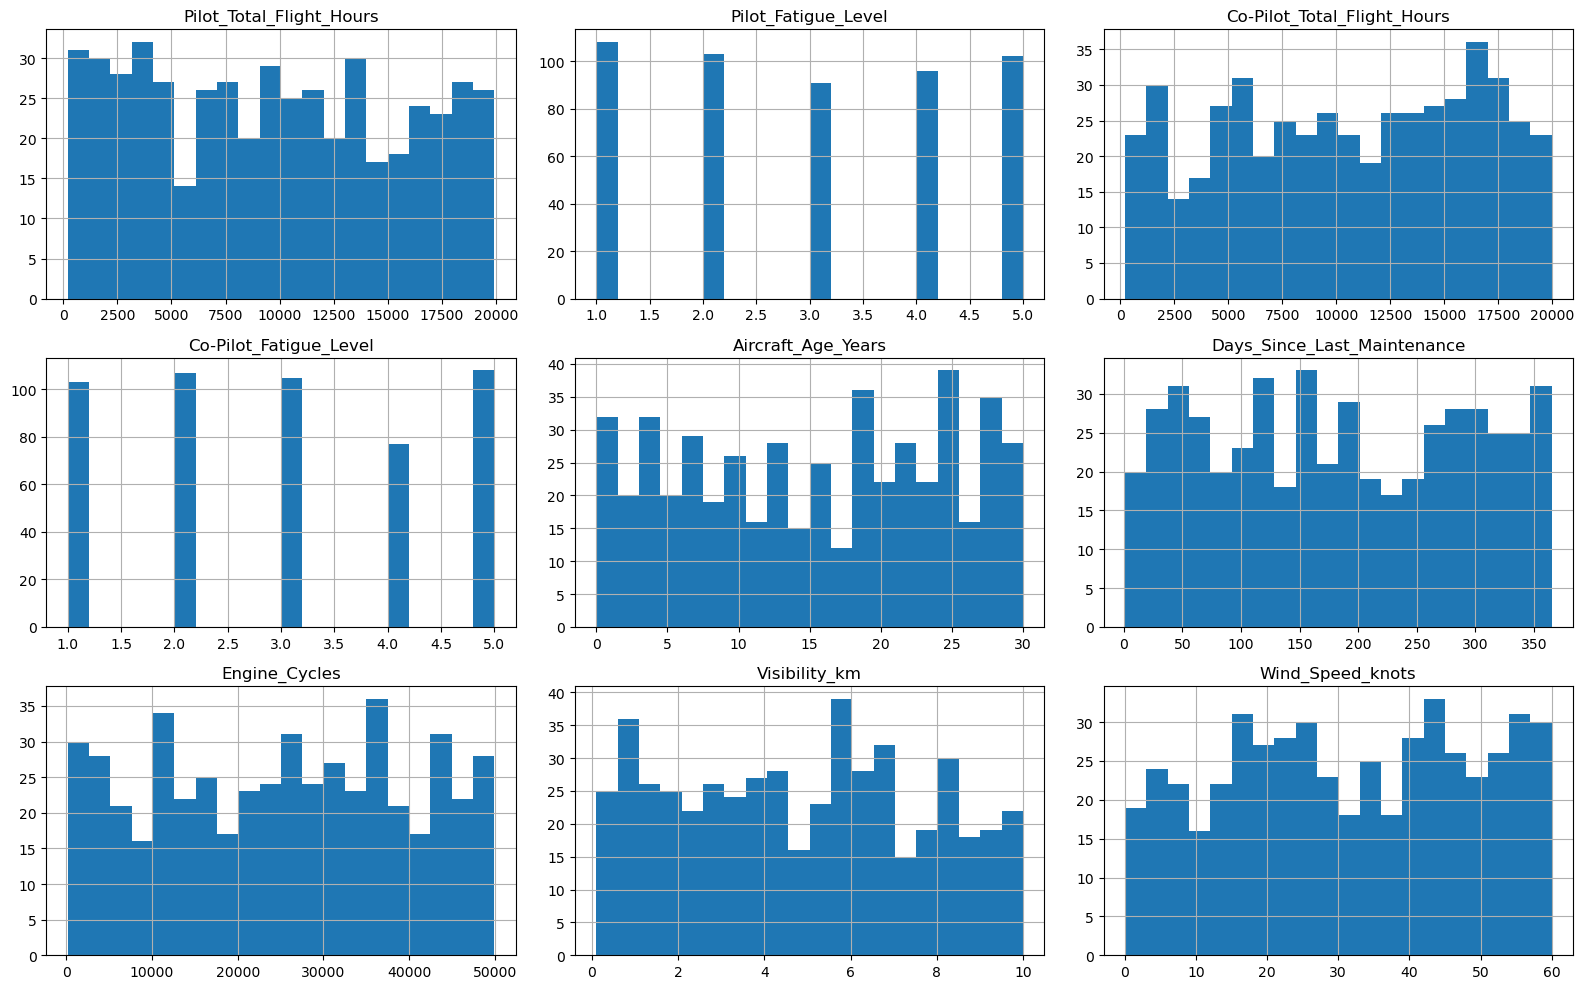

In [7]:
# Cell 6: Plot Distributions for Key Numeric Columns
df[numeric_cols].hist(bins=20, figsize=(16, 10))
plt.tight_layout()
plt.show()


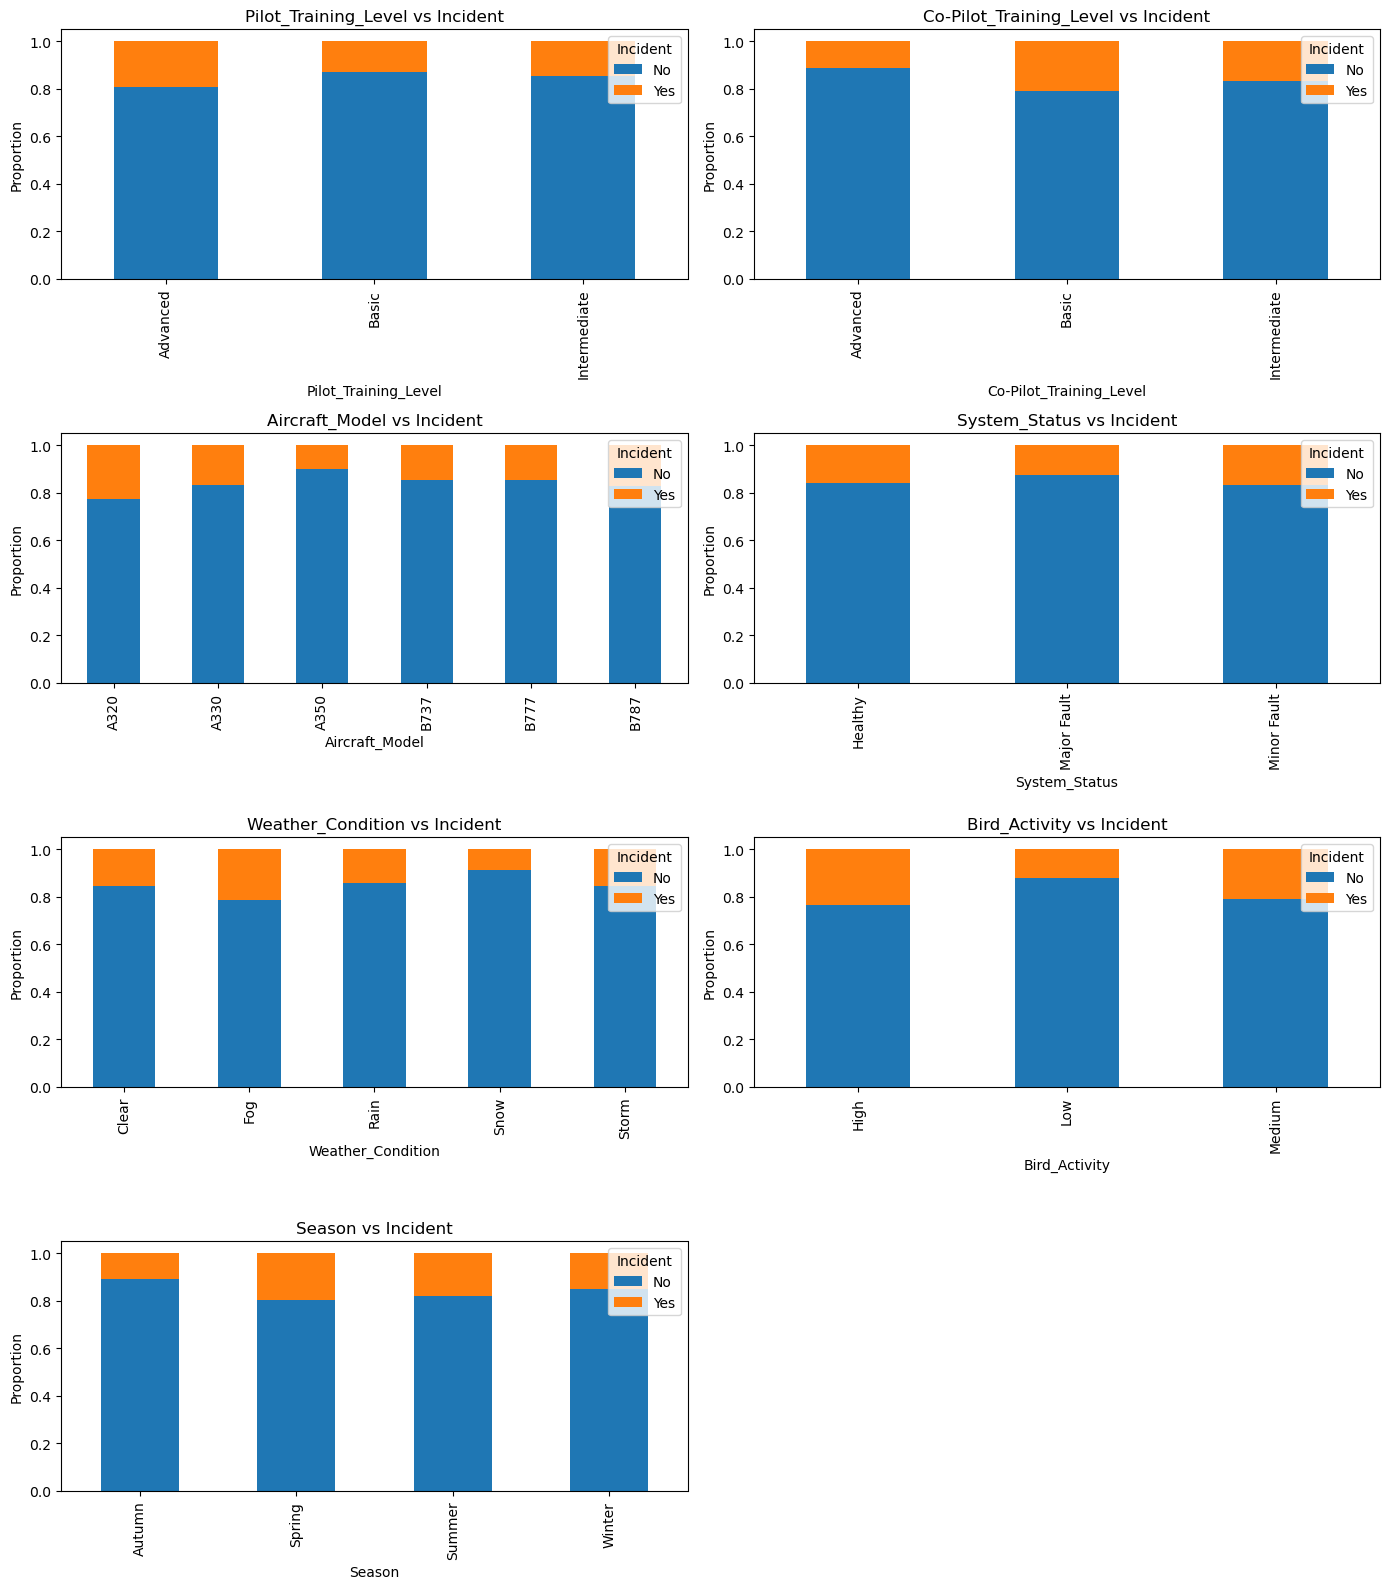

In [8]:
# Cell 7: Categorical Features vs Incident (Subplot Style)
cat_cols = df.select_dtypes(include='object').drop(columns=['Incident']).columns
n_cols = 2
n_rows = int(np.ceil(len(cat_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ctab = pd.crosstab(df[col], df['Incident'], normalize='index')
    ctab.plot(kind='bar', stacked=True, ax=axes[i], title=f'{col} vs Incident')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Incident', loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## **Phase 2**

In [ ]:
# Cell 2: Load and Prepare Full Dataset
df = pd.read_excel('dataset.xlsx')
df['Incident_bin'] = (df['Incident'] == 'Yes').astype(int)

X = df.drop(columns=['Incident', 'Incident_bin'])
y = df['Incident_bin']

print("Full dataset shape:", X.shape)
print("Positive class ratio:", y.mean())


Full dataset shape: (500, 16)
Positive class ratio: 0.158


In [10]:
X

,Pilot_Total_Flight_Hours,Pilot_Fatigue_Level,Pilot_Training_Level,Co-Pilot_Total_Flight_Hours,Co-Pilot_Fatigue_Level,Co-Pilot_Training_Level,Aircraft_Model,Aircraft_Age_Years,Days_Since_Last_Maintenance,System_Status,Engine_Cycles,Weather_Condition,Visibility_km,Wind_Speed_knots,Bird_Activity,Season
0,15995,5,Intermediate,5590,3,Basic,B787,13,125,Healthy,37264,Clear,2.6,56,High,Summer
1,12164,5,Intermediate,6465,3,Intermediate,A330,25,110,Healthy,42151,Storm,8.5,22,Low,Autumn
2,4626,3,Advanced,14623,5,Intermediate,B737,18,86,Healthy,13418,Fog,4.9,42,Low,Winter
3,11563,3,Advanced,1885,5,Basic,A350,4,120,Healthy,17300,Fog,5.2,5,Medium,Summer
4,969,4,Intermediate,2633,4,Basic,B787,28,127,Healthy,182,Snow,3.2,46,High,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,13911,4,Intermediate,7323,3,Basic,B777,3,32,Healthy,38537,Rain,1.8,4,High,Spring
496,1879,5,Intermediate,7646,4,Intermediate,A350,27,74,Minor Fault,35603,Fog,1.4,47,High,Summer
497,15663,5,Advanced,8755,1,Basic,B777,7,10,Healthy,30846,Clear,1.3,31,Low,Autumn
498,16869,5,Intermediate,13595,2,Intermediate,B737,1,54,Healthy,28023,Clear,5.2,2,Low,Summer


In [56]:
# Cell 3: Preprocessing Pipeline
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [57]:
# Cell 4: Build Final Model Pipeline (Full Fit)
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

pipeline = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', model)
])

pipeline.fit(X, y)
print("✅ Full model training complete.")


✅ Full model training complete.


C:\Users\hussi\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:48:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [58]:
# Cell 5: SHAP Local Explanation (on last 3 records for demo)
# Get SHAP-ready model and transformed data
fitted_model = pipeline.named_steps['clf']
X_transformed = pipeline.named_steps['pre'].transform(X)

# Create SHAP explainer
explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(X_transformed)

# Explain the last 3 records
feature_names = pipeline.named_steps['pre'].get_feature_names_out()
for i in [-3, -2, -1]:
    print(f"\n🧾 Flight {i} — predicted risk: {fitted_model.predict_proba([X_transformed[i]])[0][1]:.2f}")
    sv = shap_values[i]
    top_features = np.argsort(np.abs(sv))[-5:][::-1]
    for j in top_features:
        print(f"  {feature_names[j]} → SHAP = {sv[j]:+.3f}")



🧾 Flight -3 — predicted risk: 0.97
  num__Pilot_Total_Flight_Hours → SHAP = +1.379
  cat__Co-Pilot_Training_Level_Basic → SHAP = +1.095
  num__Pilot_Fatigue_Level → SHAP = +0.972
  cat__Pilot_Training_Level_Advanced → SHAP = +0.868
  num__Wind_Speed_knots → SHAP = +0.436

🧾 Flight -2 — predicted risk: 0.04
  num__Pilot_Total_Flight_Hours → SHAP = -0.865
  num__Pilot_Fatigue_Level → SHAP = +0.728
  cat__Bird_Activity_Medium → SHAP = -0.554
  cat__Season_Summer → SHAP = +0.418
  cat__Season_Spring → SHAP = -0.371

🧾 Flight -1 — predicted risk: 0.01
  num__Engine_Cycles → SHAP = -0.806
  cat__Season_Spring → SHAP = -0.649
  cat__Weather_Condition_Fog → SHAP = +0.632
  num__Aircraft_Age_Years → SHAP = -0.597
  cat__Co-Pilot_Training_Level_Advanced → SHAP = -0.458


In [ ]:
# Cell 6: Save Trained Pipeline
joblib.dump(pipeline, 'model_(pipeline).pkl')
print("✅ Model pipeline saved to 'model_(pipeline).pkl'")

✅ Model pipeline saved to 'incident_risk_pipeline.pkl'


In [62]:
# take samples 

# Save a random sample (or a specific row) from the original data
for i in range(3):
    sample = X.sample(1)
    sample.to_csv(f"sample_input_{i}.csv", index=False)
    print(f"✅ Sample input {i} saved to 'sample_input_{i}.csv'")


✅ Sample input 0 saved to 'sample_input_0.csv'
✅ Sample input 1 saved to 'sample_input_1.csv'
✅ Sample input 2 saved to 'sample_input_2.csv'
